I computed realizations of multiple HODs for a few statistics in the darksky boxes. This notebook is gonna combine them into a jackknife covmat. It'll also add some estimate of the shape noise contribution. 

In [1]:
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
import matplotlib.colors as colors

In [2]:
cmap = sns.diverging_palette(240, 10, n=7, as_cmap = True)

In [3]:
import numpy as np
from glob import glob
from os import path
from copy import deepcopy

In [4]:
#shape_noise_covmat = np.load('/u/ki/swmclau2/Git/pearce/bin/covmat/shape_noise.npy')
shape_noise_covmat = np.load('./Hankel_transform/shape_noise.npy')

In [5]:
print np.sqrt(np.diag(shape_noise_covmat))

[ 1.0263207   0.98494148  0.90722623  0.69274081  0.57677226  0.45103709
  0.32990732  0.23736836  0.17742547  0.13398334  0.10010477  0.07595037
  0.05802125  0.04515957  0.03575584  0.02910926  0.02429026  0.02063339]


In [6]:
darksky_h = 0.7036893781978598

In [7]:
output_dir = '/home/users/swmclau2/Git/pearce/bin/covmat/ds14_covmat_v2/'

In [8]:
outputs = sorted(glob(path.join(output_dir, 'wp_ds_cic_darksky_obs_???_v2.npy')))
print len(outputs)

512


In [9]:
N = len(outputs) # Should be 512, but a few may not have finished. Should make sure that those get reestarted, but likely not super important
all_outputs = np.zeros((N, 5,  2*18 + 14)) # num bins and num HODs 

In [10]:
2*18+14

50

In [11]:
for i,output_file in enumerate(outputs):
    if i == 0:
        continue
    output = np.load(output_file)
    all_outputs[i] = output#.mean(axis = 0)


In [12]:
all_outputs[0] = all_outputs[1:].mean(axis = 0)

In [13]:
all_outputs.shape

(512, 5, 50)

In [14]:
# undo a little h error of mine. 
# WARNING i've since corrected this so it will no longer be necessary with new computations
#all_outputs[:, :, 18:36]*=darksky_h**2

In [15]:
# I'm waiting for my v3 calculation to finish. In the interim i will just divide out the h scaling of wp (ds is already corrected)
all_outputs[:, :, :18]*=darksky_h**2

In [16]:
rp_bins = np.logspace(-1.0, 1.6, 19)
cic_bins = np.round(np.r_[np.linspace(1, 9, 8), np.round(np.logspace(1,2, 7))] )

In [17]:
cic_bins

array([   1.,    2.,    3.,    4.,    6.,    7.,    8.,    9.,   10.,
         15.,   22.,   32.,   46.,   68.,  100.])

In [18]:
rp_points = (rp_bins[1:]+rp_bins[:-1])/2.0
cic_points = (cic_bins[1:]+cic_bins[:-1])/2.0

In [19]:
all_outputs[:,4,:18]

array([[  1.04157101e+04,   8.66945329e+03,   7.09481334e+03, ...,
          2.87028392e+01,   1.84952633e+01,   1.09154581e+01],
       [  1.04680664e+04,   8.60450899e+03,   7.09470549e+03, ...,
          2.78965059e+01,   1.86792779e+01,   1.11918223e+01],
       [  1.03088401e+04,   8.52480794e+03,   6.96932830e+03, ...,
          2.68123082e+01,   1.80605665e+01,   1.02564184e+01],
       ..., 
       [  1.05262876e+04,   8.77669763e+03,   7.20277077e+03, ...,
          2.96653303e+01,   1.86579813e+01,   1.12295979e+01],
       [  1.04069210e+04,   8.74026145e+03,   7.15423762e+03, ...,
          2.87263371e+01,   1.84032886e+01,   1.03660267e+01],
       [  1.05043353e+04,   8.76246150e+03,   7.15709892e+03, ...,
          2.91945773e+01,   1.87150401e+01,   1.15291305e+01]])

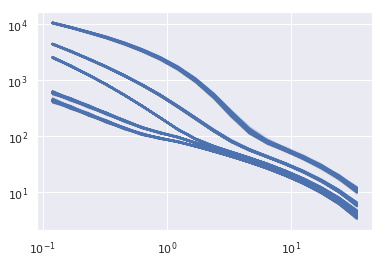

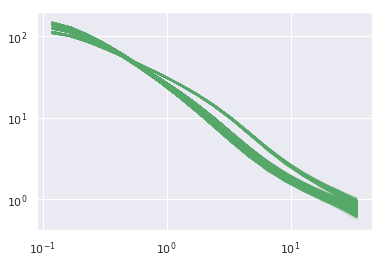

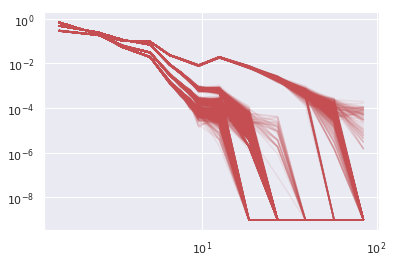

In [20]:
for hod_idx in xrange(5):
    color = 'b' 
    plt.plot(rp_points, (all_outputs[:,hod_idx, :18]).T, alpha = 0.1, color = color)
    plt.loglog();
plt.show();
for hod_idx in xrange(4):
    plt.plot(rp_points, (all_outputs[:,hod_idx, 18:36]).T, alpha = 0.1, color = 'g')
    plt.loglog();
plt.show();

for hod_idx in xrange(4):
    plt.plot(cic_points, all_outputs[:, hod_idx, 36:].T, alpha = 0.1, color = 'r')
    plt.loglog();
plt.show();

In [21]:
mean = all_outputs.mean(axis = 0)

In [22]:
def cov_to_corr(cov):
    std = np.sqrt(np.diag(cov))
    
    denom = np.outer(std, std)
    
    return cov/denom

In [23]:
np.zeros(len(cic_bins)-1)

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [24]:
# from my HOD mock on planck
#planck_y = np.array([3.67046115e+03, 2.68587097e+03, 1.86704547e+03, 1.33957041e+03,
#       9.30848932e+02, 6.45761466e+02, 4.44257796e+02, 3.02746585e+02,
#       2.09074584e+02, 1.52330606e+02, 1.14548962e+02, 8.90682088e+01,
#       6.94674502e+01, 5.30164183e+01, 3.92803031e+01, 2.74329581e+01,
#       1.77901804e+01, 1.03439673e+01, 8.12760963e+01, 6.53112366e+01,
#       5.11718897e+01, 3.92571969e+01, 2.95591990e+01, 2.18952850e+01,
#       1.59647482e+01, 1.14391216e+01, 7.99808271e+00, 5.44370980e+00,
#       3.61379155e+00, 2.33425032e+00, 1.55491234e+00, 1.10505031e+00,
#       8.02946770e-01, 6.28019530e-01, 5.08370232e-01, 4.01059480e-01,
#      0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.              ])

In [25]:
# from my HOD mock on Box 1 
# for the time being, a place holder with the right h scaling 
import numpy as np
wp_hod = np.load('/home/users/swmclau2/Git/pearce/bin/mock_measurements/HOD4mock_wp.npy')
ds_hod = np.load('/home/users/swmclau2/Git/pearce/bin/mock_measurements/HOD4mock_ds.npy')

planck_y = np.r_[wp_hod, ds_hod, np.zeros(len(cic_bins)-1)]

In [26]:
planck_y.shape

(50,)

In [27]:
mean = all_outputs.mean(axis = 0)
R =(all_outputs - mean)

corr = np.zeros((R.shape[2], R.shape[2]))
yerr_ratio = np.zeros((R.shape[2]))
for i in xrange(R.shape[1]):
    c= R[:,i].T.dot(R[:,i])/(N-1)
    corr += cov_to_corr(c)
    yerr_ratio += np.sqrt(np.diag(c))/mean[i]
    
    
corr/= (mean.shape[0])#*(N-1)
yerr_ratio/=(mean.shape[0])

In [28]:
print yerr_ratio

[ 0.02115109  0.0183483   0.01744804  0.01716035  0.01625753  0.01611677
  0.0161818   0.01663322  0.01805861  0.01930252  0.02058216  0.01986416
  0.01732619  0.01736562  0.01966843  0.02300119  0.02934295  0.04283084
  0.01391396  0.01023869  0.00805139  0.00623074  0.00519129  0.00422603
  0.00403115  0.00486841  0.00621156  0.0083079   0.01069009  0.01347838
  0.01575578  0.01895495  0.0224091   0.02887563  0.03836187  0.05257422
  0.00995335  0.01223205  0.01341301  0.01555462  0.03699359  0.05989768
  0.09231545  0.13713854  0.19617507  1.24801861  3.87076714  0.06443822
  0.16385223  0.62735347]


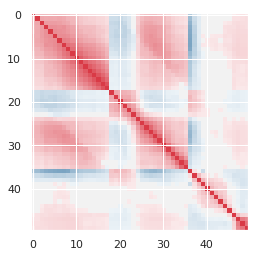

In [29]:
plt.imshow(corr, cmap = cmap, vmin=-1)

In [30]:
yerr = yerr_ratio*planck_y
cov = corr*np.outer(yerr, yerr)

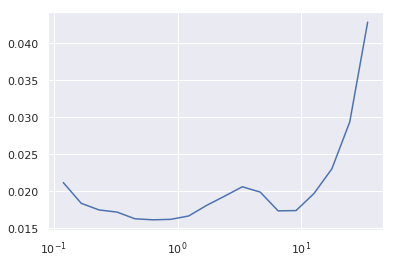

In [31]:
plt.plot(rp_points, np.sqrt(np.diag(cov))[:18]/wp_hod)
plt.xscale('log')

In [32]:
cov.shape

(50, 50)

In [33]:
np.min(cov)

-6.4875344841598768

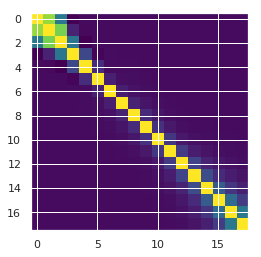

In [34]:
plt.imshow(cov_to_corr(shape_noise_covmat), cmap = 'viridis')

In [35]:
print(cov_to_corr(shape_noise_covmat))[:5, :5]

[[  1.00000000e+00   8.42406214e-01   3.86208997e-01  -2.93016279e-02
   -1.97547565e-04]
 [  8.42406214e-01   1.00000000e+00   7.88979947e-01   7.39946700e-02
   -3.67370677e-03]
 [  3.86208997e-01   7.88979947e-01   1.00000000e+00   3.73641155e-01
   -2.94861577e-02]
 [ -2.93016279e-02   7.39946700e-02   3.73641155e-01   1.00000000e+00
    1.92649413e-01]
 [ -1.97547565e-04  -3.67370677e-03  -2.94861577e-02   1.92649413e-01
    1.00000000e+00]]


In [36]:
full_cov = deepcopy(cov)

full_cov[18:36][:, 18:36] = full_cov[18:36][:, 18:36]+ shape_noise_covmat

In [37]:
corr = cov_to_corr(cov)
full_corr = cov_to_corr(full_cov)

/share/software/user/open/py-scipystack/1.0_py27/lib/python2.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in divide
  


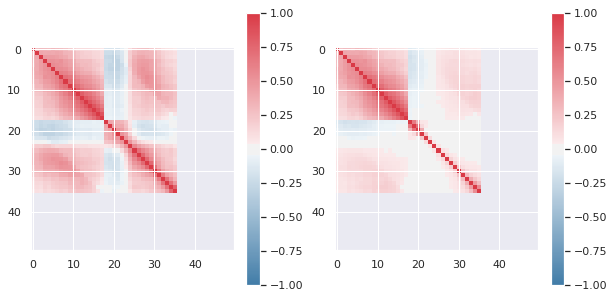

In [38]:
fig = plt.figure(figsize = (10, 5))
plt.subplot(121)
im = plt.imshow(corr, cmap = cmap, vmin = -1)
plt.colorbar(im);
plt.subplot(122)
im = plt.imshow(full_corr, cmap = cmap, vmin = -1)
plt.colorbar(im);
plt.show()

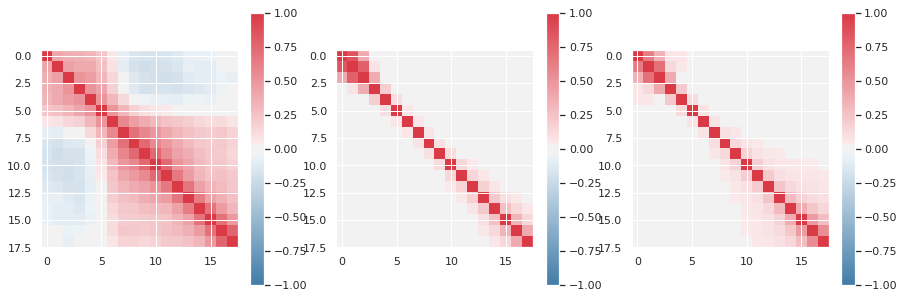

In [39]:
fig = plt.figure(figsize = (15, 5))
plt.subplot(131)
im = plt.imshow(corr[18:36][:, 18:36], cmap = cmap, vmin = -1)
plt.colorbar(im);
plt.subplot(132)
im = plt.imshow(cov_to_corr(shape_noise_covmat), cmap = cmap, vmin = -1)
plt.colorbar(im);
plt.subplot(133)
im = plt.imshow(full_corr[18:36][:, 18:36], cmap = cmap, vmin = -1)
plt.colorbar(im);
plt.show()

In [40]:
np.sqrt(np.diag(full_corr)[18:36])

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.])

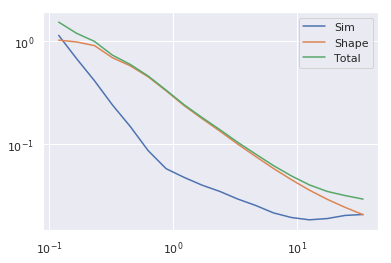

In [41]:
plt.plot(rp_points, np.sqrt(np.diag(cov)[18:36]), label = 'Sim')
plt.plot(rp_points,np.sqrt(np.diag(shape_noise_covmat)), label = 'Shape')

plt.plot(rp_points,np.sqrt(np.diag(full_cov)[18:36]), label = 'Total')
#plt.xscale('log')
plt.loglog();
plt.legend(loc = 'best')

In [42]:
print full_corr[30:30+5][:, 30:30+5]

[[ 1.          0.24458576  0.1258629   0.09232513  0.07921482]
 [ 0.24458576  1.          0.29026854  0.16679925  0.12261054]
 [ 0.1258629   0.29026854  1.          0.37132539  0.2221559 ]
 [ 0.09232513  0.16679925  0.37132539  1.          0.45441717]
 [ 0.07921482  0.12261054  0.2221559   0.45441717  1.        ]]


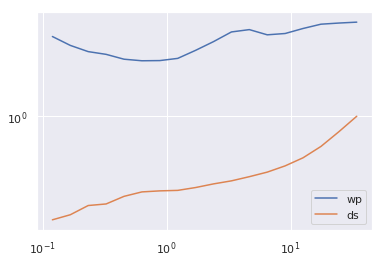

In [43]:
plt.plot(rp_points, rp_points*np.sqrt(np.diag(full_cov[:18, :18]) ), label = 'wp')
#plt.plot(rp_points, np.sqrt(np.diag(shape_noise_covmat) ), label = 'Shape')
#plt.plot(rp_points, np.sqrt(np.diag(cov[18:36, 18:36]) ), label = 'ds')
plt.plot(rp_points, rp_points*np.sqrt(np.diag(full_cov[18:36, 18:36]) ), label = 'ds')

plt.loglog()
plt.legend(loc='best')

In [44]:
print np.sqrt(np.diag(full_cov[:36][:,:36]))

[  3.07620925e+01   1.90727433e+01   1.23535448e+01   8.47149118e+00
   5.61098562e+00   3.92159382e+00   2.82069186e+00   2.09660580e+00
   1.71514982e+00   1.41820559e+00   1.19113795e+00   8.87443530e-01
   5.84366733e-01   4.28104790e-01   3.33259365e-01   2.56334608e-01
   1.87282959e-01   1.36296767e-01   1.53468275e+00   1.19556121e+00
   9.96905686e-01   7.33347349e-01   5.95521152e-01   4.59237657e-01
   3.34927828e-01   2.42093204e-01   1.81882495e-01   1.38411667e-01
   1.04304341e-01   8.00792581e-02   6.18679950e-02   4.91386849e-02
   4.02136358e-02   3.47232000e-02   3.16584070e-02   2.92509153e-02]


In [45]:
print  np.sqrt(np.diag(full_cov[18:36, 18:36]) )

[ 1.53468275  1.19556121  0.99690569  0.73334735  0.59552115  0.45923766
  0.33492783  0.2420932   0.18188249  0.13841167  0.10430434  0.08007926
  0.06186799  0.04913868  0.04021364  0.0347232   0.03165841  0.02925092]


In [46]:
#emu covs
emu_cov_fnames = ['/home/users/swmclau2/Git/pearce/bin/optimization/wp_hod_emu_cov_lpw.npy',
                  '/home/users/swmclau2/Git/pearce/bin/optimization/ds_hod_emu_cov_lpw.npy']

In [47]:
emu_cov = np.zeros_like(full_cov[:36][:, :36])

for i, fname in enumerate(emu_cov_fnames):
    
    emu_cov[i*18:(i+1)*18][:, i*18:(i+1)*18] = np.load(fname)

In [48]:
emu_corr = cov_to_corr(emu_cov)

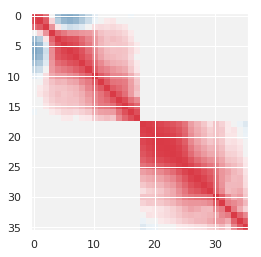

In [49]:
plt.imshow(emu_corr, cmap = cmap, vmin = -1)

In [50]:
full_emu_cov = full_cov[:36][:, :36] + emu_cov

In [51]:
print np.sqrt(np.diag(full_emu_cov[:36][:,:36]))

[  1.66594178e+02   8.89928604e+01   3.69297005e+01   2.31250906e+01
   1.99927977e+01   1.56834821e+01   1.04179897e+01   6.41893607e+00
   4.05733695e+00   2.61782052e+00   1.71328266e+00   1.33732835e+00
   1.10448492e+00   8.86267087e-01   7.22489640e-01   7.18075564e-01
   6.69049096e-01   7.31140901e-01   2.27108523e+00   1.91152556e+00
   1.57577663e+00   1.21654847e+00   9.49181785e-01   6.87014508e-01
   4.82615183e-01   3.35249779e-01   2.39954084e-01   1.79088493e-01
   1.29746873e-01   9.36757485e-02   7.09118359e-02   5.51060797e-02
   4.46276274e-02   4.01180497e-02   3.86415658e-02   3.99514694e-02]


In [52]:
full_emu_corr = cov_to_corr(full_emu_cov)

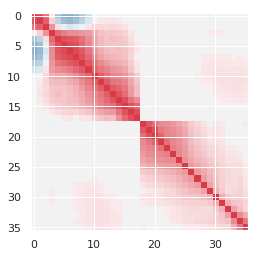

In [53]:
plt.imshow(full_emu_corr, cmap = cmap, vmin = -1)

In [54]:
mean[:,:18].mean(axis=0)

array([ 3668.07404364,  2902.11055106,  2259.28876312,  1747.23101511,
        1314.13819896,   961.73003815,   681.21744699,   456.03321199,
         284.29843941,   165.60452997,    93.85437707,    58.5079143 ,
          41.73921732,    31.06993947,    22.54371083,    15.55525894,
          10.00148362,     5.82411801])

In [55]:
print np.sqrt(np.diag(full_cov[:18, :18]) )/wp_hod#mean[:-1, :18].mean(axis=0)
print np.sqrt(np.diag(emu_cov[:18, :18]) )/wp_hod#mean[:-1, :18].mean(axis=0)

[ 0.02115109  0.0183483   0.01744804  0.01716035  0.01625753  0.01611677
  0.0161818   0.01663322  0.01805861  0.01930252  0.02058216  0.01986416
  0.01732619  0.01736562  0.01966843  0.02300119  0.02934295  0.04283084]
[ 0.11257542  0.08362331  0.04915431  0.04358714  0.05559994  0.0624077
  0.05753379  0.04813098  0.03871457  0.02994834  0.02127914  0.02239354
  0.02778845  0.03147813  0.03783302  0.06018846  0.10063401  0.22573127]


In [56]:
np.sqrt(np.diag(full_emu_cov[:18, :18]) )/mean[:-1, :18].mean(axis=0)

array([ 0.084089  ,  0.06094254,  0.03515749,  0.03095805,  0.03862424,
        0.04440366,  0.04353017,  0.03993588,  0.03725065,  0.03432565,
        0.03071818,  0.03149649,  0.03391626,  0.03617799,  0.04062195,
        0.05853067,  0.08492585,  0.16064501])

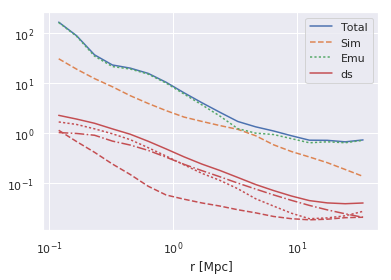

In [57]:
plt.plot(rp_points, np.sqrt(np.diag(full_emu_cov[:18, :18]) ), label = 'Total')
plt.plot(rp_points, np.sqrt(np.diag(cov[:18, :18]) ), ls = '--', label = 'Sim')
plt.plot(rp_points, np.sqrt(np.diag(emu_cov[:18, :18]) ), ls = ':', label = 'Emu')


plt.plot(rp_points, np.sqrt(np.diag(full_emu_cov[18:36, 18:36])) , label = 'ds', color ='r')
plt.plot(rp_points, np.sqrt(np.diag(cov[18:36, 18:36]) ),  color = 'r', ls = '--')
plt.plot(rp_points, np.sqrt(np.diag(emu_cov[18:36, 18:36]) ), color = 'r', ls = ':')
plt.plot(rp_points, np.sqrt(np.diag(shape_noise_covmat)), color = 'r',  ls = '-.')

#plt.ylabel('Delta Sigma Unc')
plt.xlabel('r [Mpc]')
plt.loglog()
plt.legend(loc='best')

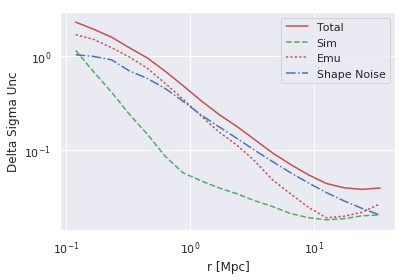

In [58]:
#plt.plot(rp_points, np.sqrt(np.diag(cov[18:36, 18:36]) ), label = 'ds')
plt.plot(rp_points, np.sqrt(np.diag(full_emu_cov[18:36, 18:36])) , label = 'Total', color ='r')
plt.plot(rp_points, np.sqrt(np.diag(cov[18:36, 18:36]) ),  color = 'g', label = 'Sim', ls = '--')
plt.plot(rp_points, np.sqrt(np.diag(emu_cov[18:36, 18:36]) ), color = 'r', ls = ':', label = 'Emu')
plt.plot(rp_points, np.sqrt(np.diag(shape_noise_covmat)), color = 'b', label = 'Shape Noise',ls = '-.')

plt.ylabel('Delta Sigma Unc')
plt.xlabel('r [Mpc]')
plt.loglog()
plt.legend(loc='best')

In [59]:
0.7**2

0.48999999999999994